### references
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load data


In [2]:
##### Load train and Test set

train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
IDtest = test["PassengerId"]

### 2.2 Outlier detection


In [3]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%) => 1 사분위 수
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%) => 3 사분위 수
        Q3 = np.percentile(df[col],75)
        
        # Interquartile range (IQR) => 중간에 50%의 데이터들이 흩어진 정도
        # 25%( median 아래의 중앙값 ) and 75%( median 위의 중앙값 )의 범위
        IQR = Q3 - Q1
        
        # outlier step => ??
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])



In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

# 28, 89, 342 => Fare 이상치
# 나머지 => SibSP 이상치

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
# Drop outliers => 위의 행들을 버린다.
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 joining train and test set

In [6]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# 합쳤다. train / test 둘을 => feature engineering
# => 어짜피 둘다 바꿔줘야 하기 때문에!

/Users/kimyihwan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
print(train.shape)
print(test.shape)
print(dataset.shape)

(881, 12)
(418, 11)
(1299, 12)


### 2.4 check for null and missing values


In [8]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

# Age와 Cabin의 missing value를 봐야 한다.
# Survived

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values


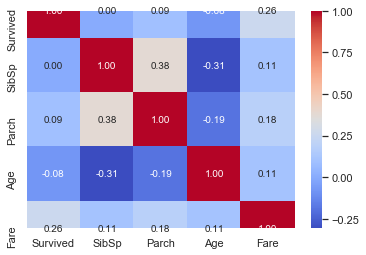

In [11]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

# 여기서는 Fare만이 약간의 상관관계를 보였다.
# 다른 값들이 필요없다는 것이 아니라,
# 상관관계가 보이도록 만들어줄 수 있다. 
# => 각 열들에 대해 자세히 알아보자.

- SibSP

/Users/kimyihwan/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/kimyihwan/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


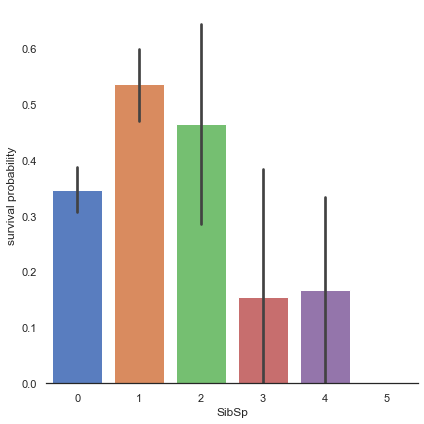

In [12]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

# 0 또는 1~2에서 생존율이 더 높은 것을 확인
# 새롭게 feature를 재구성할 수 있겠다!

- Parch

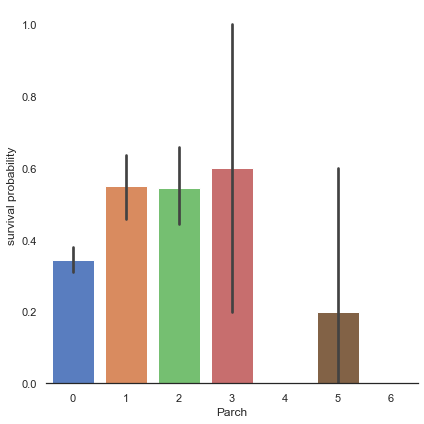

In [13]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

# single(0)이거나 5,6 처럼 큰 값, 3~4처럼 중간값이 아닌 1~2가 생존이 좋다.
# => 3에는 이상치로 추정되는 값이 많다(검정 선 => 신뢰구간 외 데이터)
# ** 3에 표준편차가 있음을 주의?

- Age

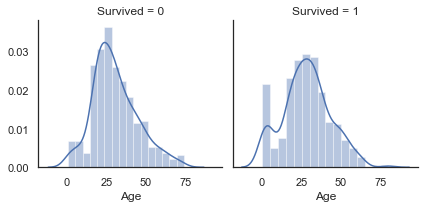

In [14]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

# 0과 1의 분포가 비슷하여 분포 상으로는 잘 안보인다.
# 생존 그래프를 보면 어릴수록 생존율이 더 높음을 알 수 있다.

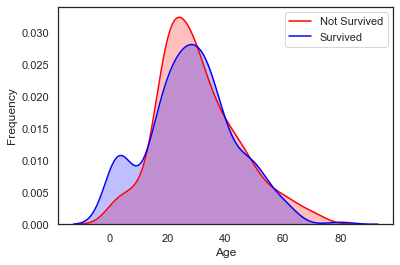

In [15]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

# 0~5세에서 확연한 상승 폭을 볼 수 있다.

- Fare

In [16]:
dataset["Fare"].isnull().sum()

1

In [17]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

# 결측치를 채우는데 1개이기에,  예측에 영향을 덜 주는 median값으로 준다.

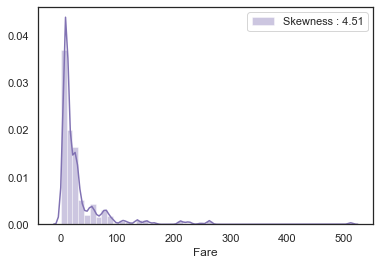

In [18]:
# Explore Fare distribution 
# Skewness => 비뚤어진 정도, 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

# 너무 치우쳐있어서, scale해도 쓰기 어려울 듯하다.
# => 이런 상황에는, log를 활용해서 skew정도를 줄인다.

In [19]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

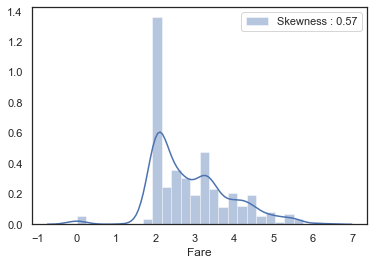

In [20]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

# 깔끔해졌다.

### 3.2 Categorical values


- Sex

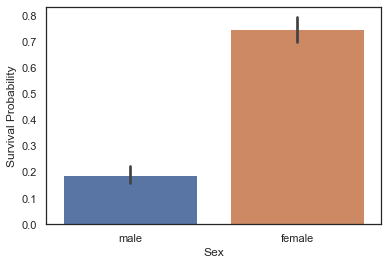

In [21]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")




In [22]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


In [23]:
# 척 보기에도 중요한 feature임이 보인다.
# Titanic movie (1997), "Women and children first".

- Pclass

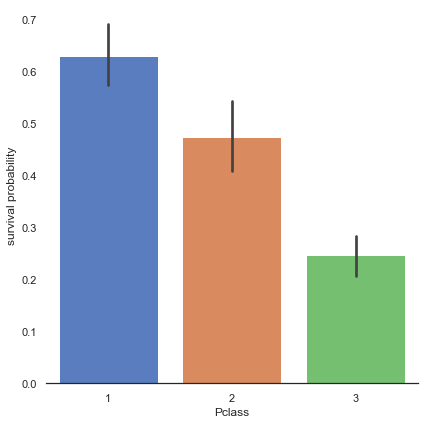

In [24]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

# 바로 보인다. => Pclass가 작아질 수록 생존율이 높다.

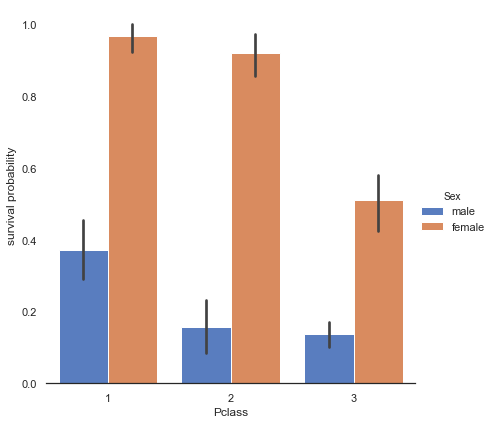

In [25]:
# Explore Pclass vs Survived by Sex
# => 기준(hue)에 성별만 추가
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

# 둘을 같이보니 확연하게 보인다.

- Embarked

In [26]:
dataset["Embarked"].isnull().sum()


2

In [27]:
dataset["Embarked"].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [28]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

# S가 가장많으니 결측치를 S로 처리

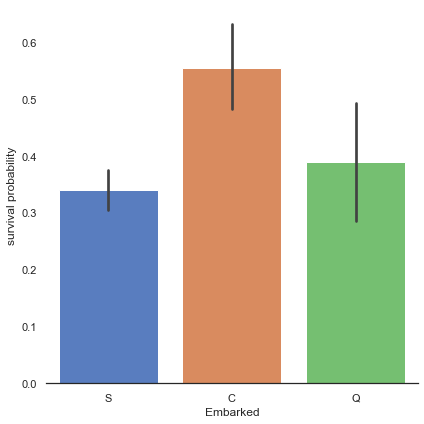

In [29]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

# C가 가장 많다.
# C에서 Pclass가 1이 가장 많지 않을까??

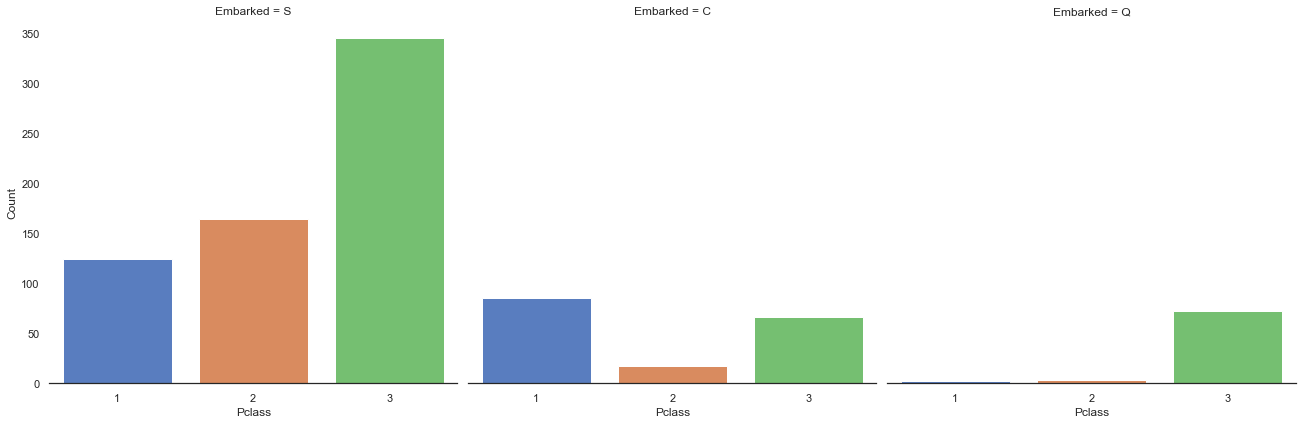

In [30]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

# S, Q 에는 3등급이 많지만 C에는 1등급이 많다.
# 1등급이 왜 높을까? => 탈출에 용이한 자리였을 수도 있다.

## 4. Filling missing Values


### 4.1 Age


In [31]:
dataset.isnull().sum()

# Age에는 254개의 결측치가 있다.

Age             256
Cabin          1007
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

/Users/kimyihwan/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/kimyihwan/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/kimyihwan/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) h

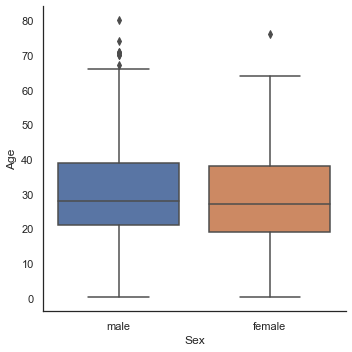

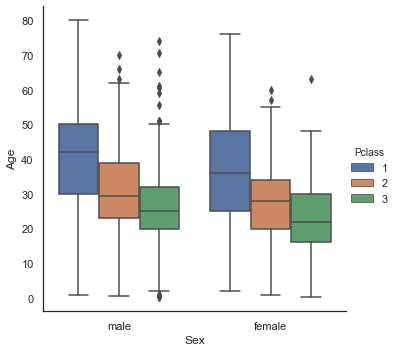

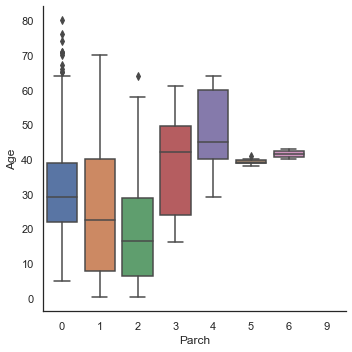

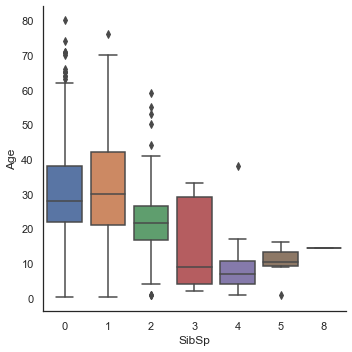

In [32]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

# 목표는 나이 결측치 판별!!
# 남녀는 비슷하지만 남자가 조금 더 나이대가 높다.
# => 성별은 나이 결측치 판별에 좋지 않다.

# 남녀불문, 등급이 높을수록 나이대가 높다.
# => 핵심 feature

# 가족 수가 많을수록 나이대가 높아지는 경향이 있다. ( 중간이 떨어진다. )
# 동승자가 많아질수록 나이대가 조금 낮아진다.
# => 가족이 많을수록, 나이 older / 배우자, 형제가 많을수록, 나이 younger


In [33]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})
# dataset["Sex"] = dataset["Sex"].astype(int)

# 남녀를 카테고리성 데이터로 치환!

In [34]:
dataset.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex              int64
SibSp            int64
Survived       float64
Ticket          object
dtype: object

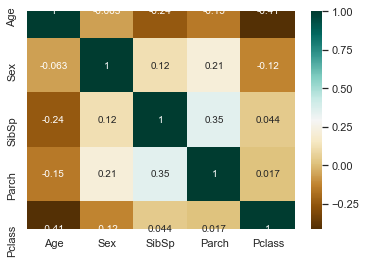

In [35]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

# 성별은 결측치때문에 안나오는 것같다?
# Pclass가 관계가 가장 많고, SibSP / Parch도 많이 낮지만 쓰도록 결정

- Age 결측치는 세 칼럼이 겹치는 median값으로 해본다.

In [36]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    # 전체 age의 중앙값
    age_med = dataset["Age"].median()
    # 결측치 행의 세 칼럼값이랑 같은 것들의 age 중앙값
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    # 동일한 행이 있다면? 예측 중앙값을..
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    # 없으면 전체 중앙값을..
    else :
        dataset['Age'].iloc[i] = age_med


/Users/kimyihwan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


/Users/kimyihwan/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/kimyihwan/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


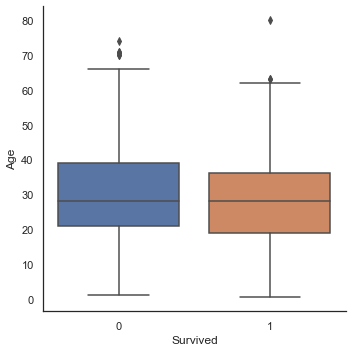

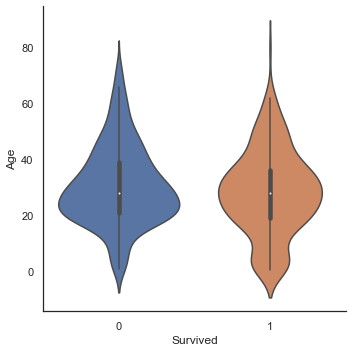

In [37]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

# 박스플롯 => 크게 눈에 띄지 않는다.
# => 생존 / 비생존의 중앙값이 차이점을 거의 가지지 않는다.
# 바이올린플롯 => 어린 나이가 생존이 더 한다고 추정가능할 듯?

## 5. Feature engineering


### 5.1 Name/Title


In [38]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- 이름의 타이틀(Mrs, Mr ... etc) 등이 의미를 가질 수 있다.

In [39]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [40]:
dataset

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,Mr
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,Mrs
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,25.0,NaN,S,2.085672,"Spector, Mr. Woolf",0,1305,3,0,0,NaN,A.5. 3236,Mr
1295,39.0,C105,C,4.690430,"Oliva y Ocana, Dona. Fermina",0,1306,1,1,0,NaN,PC 17758,Dona
1296,38.5,NaN,S,1.981001,"Saether, Mr. Simon Sivertsen",0,1307,3,0,0,NaN,SOTON/O.Q. 3101262,Mr
1297,25.0,NaN,S,2.085672,"Ware, Mr. Frederick",0,1308,3,0,0,NaN,359309,Mr


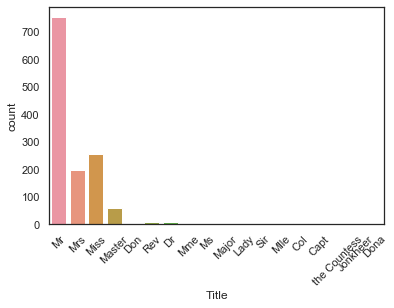

In [41]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

# 총 17개가 있으나, 대표적인 4개로 통합시켜버리자.

In [42]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(
    ['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map(
    {"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

# Rare를 남자에 해당하면 Mr로 / 여자 => Miss로 해주면 안됬을까?

In [43]:
dataset

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,2
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,1
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,1
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,25.0,NaN,S,2.085672,"Spector, Mr. Woolf",0,1305,3,0,0,NaN,A.5. 3236,2
1295,39.0,C105,C,4.690430,"Oliva y Ocana, Dona. Fermina",0,1306,1,1,0,NaN,PC 17758,3
1296,38.5,NaN,S,1.981001,"Saether, Mr. Simon Sivertsen",0,1307,3,0,0,NaN,SOTON/O.Q. 3101262,2
1297,25.0,NaN,S,2.085672,"Ware, Mr. Frederick",0,1308,3,0,0,NaN,359309,2


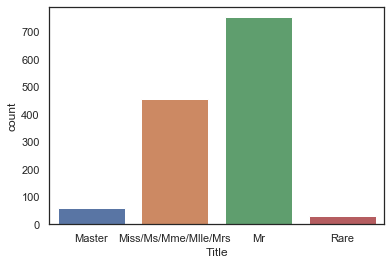

In [44]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

# Title별로 몇개씩 있느냐 => countplot
# Mr => 남자가 탑승 많이 했구나

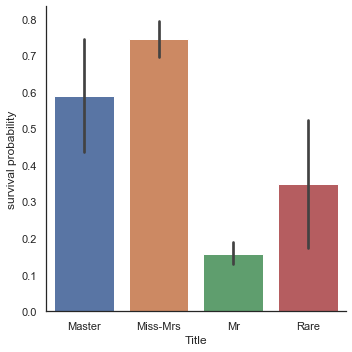

In [45]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

# Title - 생존율 비교
# 남자(Mr) 생존율 극악 / 여자 Title이 더 잘 살아나갔다.
# Rare, Master Title이 많이 살았다.

In [46]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

# 네임은 이제 필요없어짐

In [47]:
dataset.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,0,1,3,0,1,0.0,A/5 21171,2
1,38.0,C85,C,4.266662,0,2,1,1,1,1.0,PC 17599,1
2,26.0,NaN,S,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,3.972177,0,4,1,1,1,1.0,113803,1
4,35.0,NaN,S,2.085672,0,5,3,0,0,0.0,373450,2


### 5.2 Family size

- Fsize ( Family size )  
  => 형제 수, 부모/자식 수를 통해 인원들의 전체가족수를 구해보자.

In [48]:
# Create a family size descriptor from SibSp and Parch => 본인 포함(1)
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1


In [49]:
dataset.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize
0,22.0,NaN,S,1.981001,0,1,3,0,1,0.0,A/5 21171,2,2
1,38.0,C85,C,4.266662,0,2,1,1,1,1.0,PC 17599,1,2
2,26.0,NaN,S,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1,1
3,35.0,C123,S,3.972177,0,4,1,1,1,1.0,113803,1,2
4,35.0,NaN,S,2.085672,0,5,3,0,0,0.0,373450,2,1


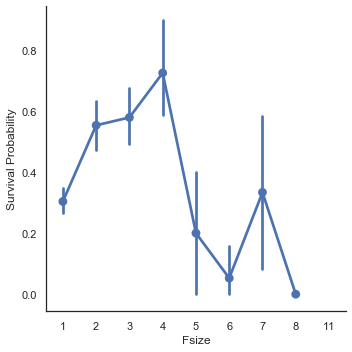

In [50]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

# 가족 수가 많아지면 생존율이 낮아진다.

In [51]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

# 카테고리성 => one hot encoding 느낌인가?
# 카테고리를 나누자 => 1, 2, 3-4, 5-...

# dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
# dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if 2 <= s <= 3 else 0)
# dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if s == 4 else 0)
# dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)
# 1, 2-3, 4, 5-... => 이렇게 해도 될거 같아.

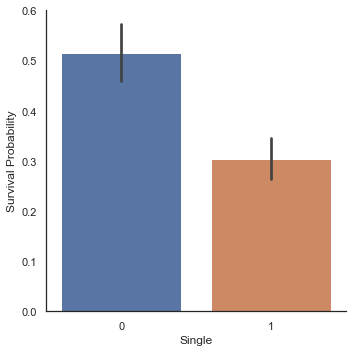

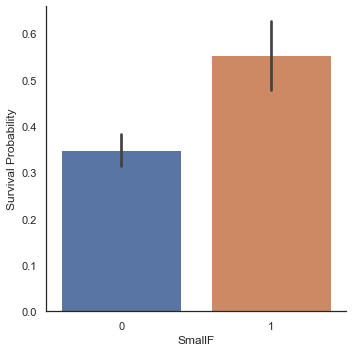

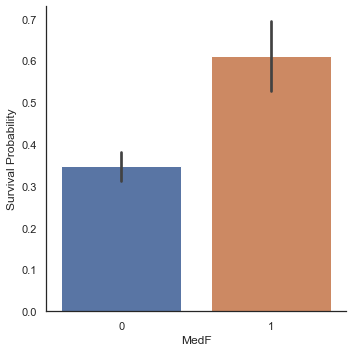

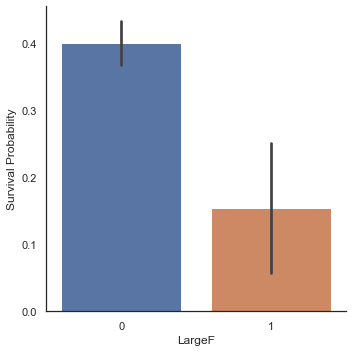

In [52]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

# small, medium(2-4)까지 생존율이 높다.
# single, large(1,5-...)는 사망율이 더 높다.

In [53]:
# one hot encoding!!
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [54]:
dataset.head(2)

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0


### 5.3 Cabin


In [55]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [56]:
# feature에 대한 describe
dataset["Cabin"].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [57]:
dataset["Cabin"].isnull().sum()

1007

In [58]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [59]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series( [i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ] )

In [60]:
dataset["Cabin"].unique()

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

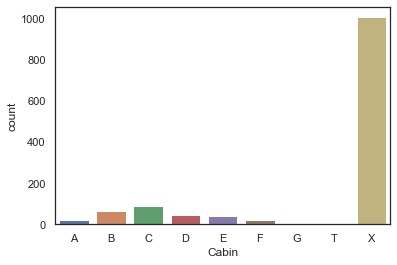

In [61]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

# C가 그나마 좀 많다.

## What is 표준편차??
- 편차 (deviation) => 관측값에서 평균 or 중앙값을 뺀 것
- 분산 (variance ) => 관측값에서 평균을 뺀 값 (=편차)을 제곱하고,  
  => 그것을 모두 더한 후 전체 갯수를 나눠서 구한다.  
  => 차이값(편차)의 제곱의 평균
  => 차이값을 그냥 더해버리면 0이 나오기 때문에 제곱해서 더한다.
- **표준편차 (standard deviation)**  
  => 분산을 제곱근한 것, 제곱으로 부풀려진 분산을 제곱근해서 다시 원래 크기로!!  
  => 간단하게! 편차를 평균한 것

#### (직관적으로)
- 뿔같은 정규분표이면, 표준편차가 작다
- 넓게 분포된 ( 산개된 ) 정규분표(분포)이면, 표준편차가 크다.  
  => 즉, 표준 편차가 크면 데이터간의 관계가 눈에 안보인다.

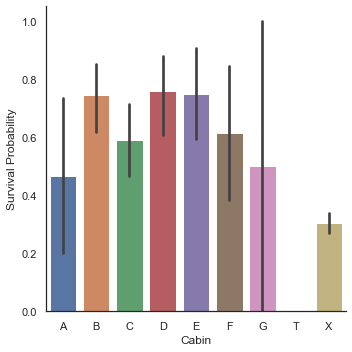

In [62]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

# 카운트 수 자체가 적어 표준편자가 눈에 띈다 ?? => NO!
# 그래프에서 눈에 띄는 올라온 값이 없다.
# => 즉, 표준편차가 커서 쓰기가 힘들지 않을까??

# 그래도! X보다 다른 탑승이 있는 것이 좀더 생존율이 높다.

In [63]:
pd.get_dummies?

In [64]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [65]:
dataset.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket', 'Fsize', 'Single', 'SmallF', 'MedF', 'LargeF',
       'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_X'],
      dtype='object')

### 5.4 Ticket

In [66]:
dataset[["Ticket", "Pclass"]].head()

,Ticket,Pclass
0,A/5 21171,3
1,PC 17599,1
2,STON/O2. 3101282,3
3,113803,1
4,373450,3


In [67]:
dataset["Ticket"].isnull().sum()
# 결측치가 없다.

0

In [79]:
Ticket = []
# cnt=0 # for test
for i in list(dataset.Ticket):
    # 숫자 값이 아니면!
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
#         print(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")
#         print("X")
        
        
#     cnt += 1 # for test
#     if cnt >10:
#         break

dataset["Ticket"] = Ticket

In [69]:
print(dataset.Ticket)
print("Unique Size = ", dataset.Ticket.unique().size)

0                A/5 21171
1                 PC 17599
2         STON/O2. 3101282
3                   113803
4                   373450
               ...        
1294             A.5. 3236
1295              PC 17758
1296    SOTON/O.Q. 3101262
1297                359309
1298                  2668
Name: Ticket, Length: 1299, dtype: object
Unique Size =  929


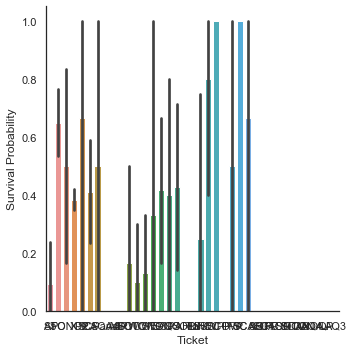

In [87]:
g = sns.catplot(y="Survived",x="Ticket",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

# 못 볼 정도다..

In [88]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [89]:
dataset.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Fsize', 'Single', 'SmallF', 'MedF', 'LargeF', 'Title_0',
       'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Cabin_X', 'T_A', 'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS',
       'T_C', 'T_CA', 'T_CASOTON', 'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP',
       'T_PC', 'T_PP', 'T_PPP', 'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW',
       'T_SCPARIS', 'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2',
       'T_SOTONOQ', 'T_SP', 'T_STONO', 'T_STONO2', 'T_STONOQ', 'T_SWPP',
       'T_WC', 'T_WEP', 'T_X'],
      dtype='object')

In [90]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [93]:
dataset.PassengerId.head()

0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

In [94]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [95]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [98]:
dataset.to_csv('./new_titanic_mid_output/new_titanic_mid.csv', index=False)

In [97]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1
